# <img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4594/logos/front_page.png"/><span style="color:blue;text-align:center;">v7 XGBoost After Feature Engineering</span>

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, 
Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 
<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4594/media/rossmann_banner2.png"/>

In [1]:
using DataFrames
using XGBoost
using Gadfly
using PyCall

@pyimport sklearn.cross_validation as cv

### Load Data

In [2]:
train = readtable("data/train_featured.csv")
test = readtable("data/test_featured.csv");

### Training Preparation

In [3]:
features = [:Store, :CompetitionDistance, :Promo, :Promo2, :SchoolHoliday,
            :StoreType, :Assortment, :StateHoliday, :DayOfWeek, :Month, :Day, 
            :Year, :WeekOfYear, :CompetitionOpen, :PromoOpen, :IsPromoMonth];

In [4]:
rmspe(yreal, ypred) = sqrt(mean(((yreal - ypred) ./ yreal) .^ 2))
function rmspe_xgb(preds::Array{Float32, 1}, dtrain::DMatrix)
    yreal = exp(get_info(dtrain, "label")) - 1
    ypred = exp(preds) - 1
    return ("rmspe", rmspe(yreal, ypred))
end

rmspe_xgb (generic function with 1 method)

In [5]:
plain_train = Array{Float64,2}(train[:, vcat(features, :Sales)])
plain_train[:, end] = log(plain_train[:, end] + 1)
X_train, X_valid = cv.train_test_split(plain_train, test_size=0.1, random_state=10)
train_x = X_train[:, 1:(size(X_train, 2)-1)]
train_y = X_train[:,end]
valid_x = X_valid[:, 1:(size(X_valid, 2)-1)]
valid_y = X_valid[:,end]
test_x = Array{Float64,2}(test[:, features]);

In [6]:
dtrain = DMatrix(train_x, label=train_y)
dtest = DMatrix(valid_x, label=valid_y);

In [7]:
num_rounds = 100
params = Dict({"objective" => "reg:linear",
               "booster" => "gbtree",
               "eta" => 0.3,
               "max_depth" => 15,
               "subsample" => 0.95
              })
watchlist = [(dtrain, "train"), (dtest, "eval")]

println("Base Model")
tic()
model = XGBoost.xgboost(dtrain, num_rounds, param=params, 
                        watchlist=watchlist, feval=rmspe_xgb)
toc()

# ptrain = XGBoost.predict(model, dtrain, output_margin=true)
# ptest  = XGBoost.predict(model, dtest, output_margin=true)

# num_rounds = 20
# set_info(dtrain, "base_margin", ptrain)
# set_info(dtest, "base_margin", ptest)
# watchlist  = [(dtrain,"train2"), (dtest,"eval2")]

# println("Tunned Model")
# tic()
# model = XGBoost.xgboost(dtrain, num_rounds, param=params, 
#                         watchlist=watchlist, feval=rmspe_xgb)
# toc()


Use "Dict{Any,Any}(a=>b, ...)" instead.


Base Model


[1]	train-rmspe:0.996850	eval-rmspe:0.996860
[2]	train-rmspe:0.981670	eval-rmspe:0.981714
[3]	train-rmspe:0.938707	eval-rmspe:0.938815
[4]	train-rmspe:0.857835	eval-rmspe:0.857936
[5]	train-rmspe:0.745979	eval-rmspe:0.745699
[6]	train-rmspe:0.620878	eval-rmspe:0.619554
[7]	train-rmspe:0.501458	eval-rmspe:0.498379
[8]	train-rmspe:0.401291	eval-rmspe:0.395514
[9]	train-rmspe:0.324366	eval-rmspe:0.318079
[10]	train-rmspe:0.272784	eval-rmspe:0.264701
[11]	train-rmspe:0.235102	eval-rmspe:0.228050
[12]	train-rmspe:0.204174	eval-rmspe:0.206832
[13]	train-rmspe:0.189429	eval-rmspe:0.194237
[14]	train-rmspe:0.181304	eval-rmspe:0.186441
[15]	train-rmspe:0.173736	eval-rmspe:0.181376
[16]	train-rmspe:0.167644	eval-rmspe:0.176364
[17]	train-rmspe:0.158737	eval-rmspe:0.167840
[18]	train-rmspe:0.153780	eval-rmspe:0.164336
[19]	train-rmspe:0.150345	eval-rmspe:0.161391
[20]	train-rmspe:0.144192	eval-rmspe:0.159749
[21]	train-rmspe:0.141266	eval-rmspe:0.158307
[22]	train-rmspe:0.135338	eval-rmspe:0.1531

elapsed time: 457

457.935207955

In [8]:
ypred = XGBoost.predict(model, test_x)
ypred_round = map(v -> v < 0? 0 : v, round(Int, exp(ypred)-1));

.935207955 seconds


### Simple Eval 

In [9]:
ypred_train = XGBoost.predict(model, train_x)
rmspe(exp(train_y) - 1, exp(ypred_train) - 1)

0.04984910363266255

In [10]:
ypred_valid = XGBoost.predict(model, valid_x)
rmspe(exp(valid_y) - 1, exp(ypred_valid) - 1)

0.11077480467189238

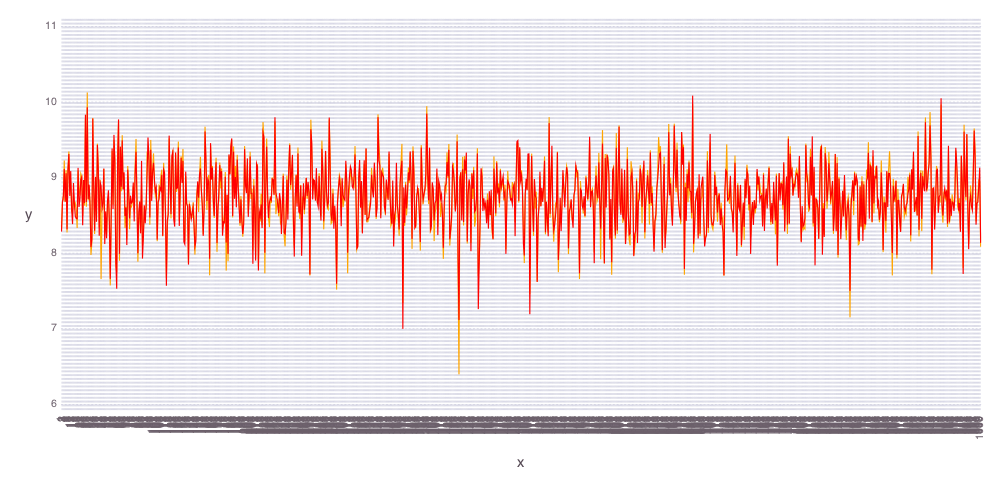

In [11]:
set_default_plot_size(1000px, 500px)
plot(
layer(x=vcat(1:1000), y=ypred_valid[1:1000], Theme(default_color=colorant"red"), Geom.line), 
layer(x=vcat(1:1000), y=valid_y[1:1000], Theme(default_color=colorant"orange"), Geom.line),
Scale.x_discrete)

### Create Submission

In [12]:
submission = DataFrame(Id=test[:Id], Sales=ypred_round)
writetable("data/submission_v7.3_xgb_nr1000_eta.1_md15_ss.5_cst.4_mcw6_ts.2_rlin_boost_pred.csv", submission, separator=',');

### Kaggle Public Result

v7.3 XGBoost gbtree nr1000 eta.1 md15 ss.5 cst.4 mcw6 ts.2 seed 1 rlin boost pred **.** (tra:.04 eva:.09 simple-eval: 0.9428)  
v7.2 XGBoost gbtree nr1200 eta.1 md10 ss.85 cst.4 mcw6 seed 1 rlin boost pred **0.99986** (tra:.093 eva:.314 simple-eval: 0.9431)  
v7.1 XGBoost gbtree nr300 eta.1 md10 ss.85 cst.4 mcw6 seed 1301 rlin **0.29130** (tra:802 eva:3419)  
v7 XGBoost gbtree nr100 eta.1 md10 ss.85 cst.4 mcw6 seed 1301 rlin (eval: 0.27048591932751403)
v5.6 + XGBoost nr2000 eta .3 md 30 ss .5 reg:linear: **0.17111** (eval: 68.48976543618694)  
v5.5 + XGBoost nr500 eta .3 md 30 ss .9 reg:linear: **0.16466** (eval: 102.72031811851865)  
v5.4 + XGBoost nr10 eta .3 md 30 ss .5 reg:linear: **0.17142** (eval: 2.403523758865878e6)  
v5.3 + XGBoost nr10 eta .3 md 15 ss .5 reg:linear: **0.22616** (eval: 4.229142277636823e6)  
v5.2 + XGBoost nr300 eta .3 md 15 ss .5 reg:linear: **0.15229** (eval: 1.7664821959061403e7)   
v5.1 + XGBoost: **0.42537** (eval: 2.1655121558566544e7)   
v4 + Random Forest 100 Trees, Feat 5: **0.30076**
v4 + Initial Random Forest: **0.30879**  
v2 + CV + Selected Features: **0.42446**  
v1 All Features - Only to set a initial score: **0.42591**  
Better than baseline benchmark that is all Zeros: **1.0000**